In [1]:
from __future__ import division
import sys
import random
import copy
import math
import json

import numpy as np
import pandas as pd
import scipy


%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

sys.path.append("../resources/")
import sct_py3
sns.set_style("ticks")
sns.set_context("talk")

output_dir = "out/"
output_suffix = ""
output_formats = [".png", ".pdf"]


mpl.rc('savefig', dpi=300)

def save_figure(fig, name):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format)
    return None

mpl.rc('savefig', dpi=300)

pd.options.mode.chained_assignment = None  # default='warn'


/Users/colleenmclaughlin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# load matricies

these data include: All 42h APF data from Li et al., 2020; 24h APF elav cells (including one cluster of auditory neruons); Adult nsyb>unc84-GFP nuclei


In [2]:
df_ORN_nSyb_adult = pd.read_csv('../data/htseq_ORN_nuclei_LogCPM_17plates_addintron_hq50k_neuron2-5.tab.gz',  sep="\t", header=0, index_col=0)

df_ORN_24h = pd.read_csv('../data/htseq_ORN_cell_LogCPM_10plates_hq50k_neuron2-5.tab.gz', sep="\t", header=0, index_col=0)

df_ORN_42h = pd.read_csv('../data/htseq_logCPM_hq.tab.gz', sep="\t", header=0, index_col=0)

df_ORN_nSyb_adult.shape, df_ORN_24h.shape, df_ORN_42h.shape  

((17472, 2829), (17472, 1892), (15908, 4203))

In [3]:
df_log_CPM_all = pd.concat([df_ORN_24h, df_ORN_42h,df_ORN_nSyb_adult],  axis = 1, sort=False)

df_log_CPM_all= df_log_CPM_all.fillna(0)

print('combined (gene,cell):'), df_log_CPM_all.shape

combined (gene,cell):


(None, (17474, 8924))

In [4]:
df_log_CPM_all.head()

,ORNcell_24h_ElavCD8GFP_P1_A10,ORNcell_24h_ElavCD8GFP_P1_A11,ORNcell_24h_ElavCD8GFP_P1_A12,ORNcell_24h_ElavCD8GFP_P1_A15,ORNcell_24h_ElavCD8GFP_P1_A16,ORNcell_24h_ElavCD8GFP_P1_A17,ORNcell_24h_ElavCD8GFP_P1_A18,ORNcell_24h_ElavCD8GFP_P1_A19,ORNcell_24h_ElavCD8GFP_P1_A1,ORNcell_24h_ElavCD8GFP_P1_A20,...,ORNnuclei_adult_AM29UNC84GFP_P3_I6,ORNnuclei_adult_AM29UNC84GFP_P3_J4,ORNnuclei_adult_AM29UNC84GFP_P3_L14,ORNnuclei_adult_AM29UNC84GFP_P3_N15,ORNnuclei_adult_AM29UNC84GFP_P3_N8,ORNnuclei_adult_AM29UNC84GFP_P3_O1,ORNnuclei_adult_AM29UNC84GFP_P3_P2,ORNnuclei_adult_AM29UNC84GFP_P3_P6,ORNnuclei_adult_AM29UNC84GFP_P3_P7,ORNnuclei_adult_AM29UNC84GFP_P3_P9
7SLRNA:CR32864,0.000000,0.953444,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,2.68672,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
a,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
abd-A,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Abd-B,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Abl,9.458788,10.285869,0.0,9.541255,7.627055,0.0,0.0,0.0,8.482902,10.318245,...,0.0,0.0,0.00000,0.0,0.0,10.899275,0.0,0.0,0.0,0.0


In [5]:
df_libs = pd.read_csv('../data/PN_ORN_libs_CNM.csv', sep=",", header=0, index_col=0)
df_libs.head()

,pooled_library,SampleID,Index,num,experiment,plate,well,num_cells,num_mapped_reads,color,genotype,colorHL,label
library,,,,,,,,,,,,,
N447Barcode_701-502,N477,1000100701-A1-flybrain-1,TAAGGCGA-ATAGAGAG,2477.0,13.0,1000100701,A1,1.0,NaN,#a3eb13,nSyb_48h_ORN,#e31a1c,nSyb_48h_ORN_P0
N447Barcode_702-502,N447,1000100701-A2-flybrain-1,CGTACTAG-ATAGAGAG,2478.0,13.0,1000100701,A2,1.0,NaN,#a3eb13,nSyb_48h_ORN,#e31a1c,nSyb_48h_ORN_P0
N447Barcode_703-502,N447,1000100701-A3-flybrain-1,AGGCAGAA-ATAGAGAG,2479.0,13.0,1000100701,A3,1.0,NaN,#a3eb13,nSyb_48h_ORN,#e31a1c,nSyb_48h_ORN_P0
N447Barcode_704-502,N447,1000100701-A4-flybrain-1,TCCTGAGC-ATAGAGAG,2480.0,13.0,1000100701,A4,1.0,NaN,#a3eb13,nSyb_48h_ORN,#e31a1c,nSyb_48h_ORN_P0
N447Barcode_705-502,N447,1000100701-A5-flybrain-1,GGACTCCT-ATAGAGAG,2481.0,13.0,1000100701,A5,1.0,NaN,#a3eb13,nSyb_48h_ORN,#e31a1c,nSyb_48h_ORN_P0


In [6]:
#open cell names for all adult RNs, all 24h RNs, and all 42h RNs
names_hq_24h = []
with open ("../resources/names_hq_24h_adult.txt") as f:
    for line in f:
        names_hq_24h.append(line.rstrip())

names_adult = []
with open ("../resources/names_ORN_hq_24h_adult_lamGFP_noAN.txt") as f:
    for line in f:
        names_adult.append(line.rstrip())
        
        
names_hq_42h_neurons = []
with open ("../resources/48h_names_hq_neurons.txt") as f:
    for line in f:
        names_hq_42h_neurons.append(line.rstrip())
        

In [7]:
# Get names of 24h ORNs
selector0 = (df_libs["label"] == "Elav_24h_ORN_P1") 
selector1 = (df_libs["label"] == "Elav_24h_ORN_P2")
selector2 = (df_libs["label"] == "Elav_24h_ORN_P3")
selector3 = (df_libs["label"] == "Elav_24h_ORN_P4")
selector4 = (df_libs["label"] == "Elav_24h_ORN_P5")
selector5 = (df_libs["label"] == "Elav_24h_ORN_P6")
selector6 = (df_libs["label"] == "Elav_24h_ORN_P7")
ORNs_24h = [x for x in list(df_log_CPM_all.columns) if ((x in df_libs.loc[selector0].index) 
                      or (x in df_libs.loc[selector1].index) 
                      or (x in df_libs.loc[selector2].index)
                      or (x in df_libs.loc[selector3].index)
                      or (x in df_libs.loc[selector4].index)
                      or (x in df_libs.loc[selector5].index)
                      or (x in df_libs.loc[selector6].index))
                      and x in names_hq_24h]





print ("Elav_ORN_24h:"), len(ORNs_24h)


Elav_ORN_24h:


(None, 1224)

In [8]:
# Get names of adult ORNs
selector7 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P1") 
selector8 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P2") 
selector9 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P3") 
selector10 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P5") 
selector11 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P6") 
selector12 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P7") 
selector13 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P8") 
selector14 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P9") 
selector15 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P10") 
selector16 = (df_libs['genotype'] == "ORNnuclei_adult_nSybLam_P2")
selector17 = (df_libs['genotype'] == "ORNnuclei_adult_nSybLam_P3")
 
ORNs_adult = [x for x in list(df_log_CPM_all.columns) if ((x in df_libs.loc[selector7].index) 
                      or (x in df_libs.loc[selector8].index) 
                      or (x in df_libs.loc[selector9].index)
                      or (x in df_libs.loc[selector10].index)
                      or (x in df_libs.loc[selector11].index)
                      or (x in df_libs.loc[selector12].index)
                      or (x in df_libs.loc[selector13].index)
                      or (x in df_libs.loc[selector14].index)
                      or (x in df_libs.loc[selector15].index)
                      or (x in df_libs.loc[selector16].index)
                      or (x in df_libs.loc[selector17].index))
                      and  x in names_adult]
print ("Adult ORNs:"), len(ORNs_adult)

Adult ORNs:


(None, 1891)

In [9]:
#get names of 42h ORNs
selector18 = (df_libs["label"] == "nSyb_48h_ORN_P0") 
selector19 = (df_libs["label"] == "nSyb_48h_ORN_P1")
selector20 = (df_libs["label"] == "nSyb_48h_ORN_P2")
selector21= (df_libs["label"] == "nSyb_48h_ORN_P4")
selector22 = (df_libs["label"] == "85A10_48h_ORN_P4")
selector23 = (df_libs["label"] == "Am29_48h_ORN_P4") 
ORNs_42h = [x for x in list(df_log_CPM_all.columns) if ((x in df_libs.loc[selector18].index) 
                      or (x in df_libs.loc[selector19].index) 
                      or (x in df_libs.loc[selector20].index)
                      or (x in df_libs.loc[selector21].index)
                      or (x in df_libs.loc[selector22].index) 
                      or (x in df_libs.loc[selector23].index))
                      and x in names_hq_42h_neurons]
print ("42h ORN"), len(ORNs_42h)

42h ORN


(None, 1016)

In [10]:
# Filter for these cells
names_All_ORN = ORNs_24h + ORNs_42h + ORNs_adult

df_All_ORN = df_log_CPM_all[list(names_All_ORN)]


print ("ORN_All:"), df_All_ORN.shape[1]

ORN_All:


(None, 4131)

# open DE genes between all three stages


In [11]:
DE_genes = []
with open ("../data/Figure1/416_DE_genes.txt") as f:
    for line in f:
        DE_genes.append(line.rstrip())
print ("DE_genes:"), len(DE_genes)

DE_genes:


(None, 416)

# heamap for neuronal and antennal genes

In [12]:
X = df_All_ORN
genes = ["nSyb","CadN","brp","Syt1", "elav",'peb', 'repo',]
Z = X.loc[genes]
print (Z.shape)

(7, 4131)


[]

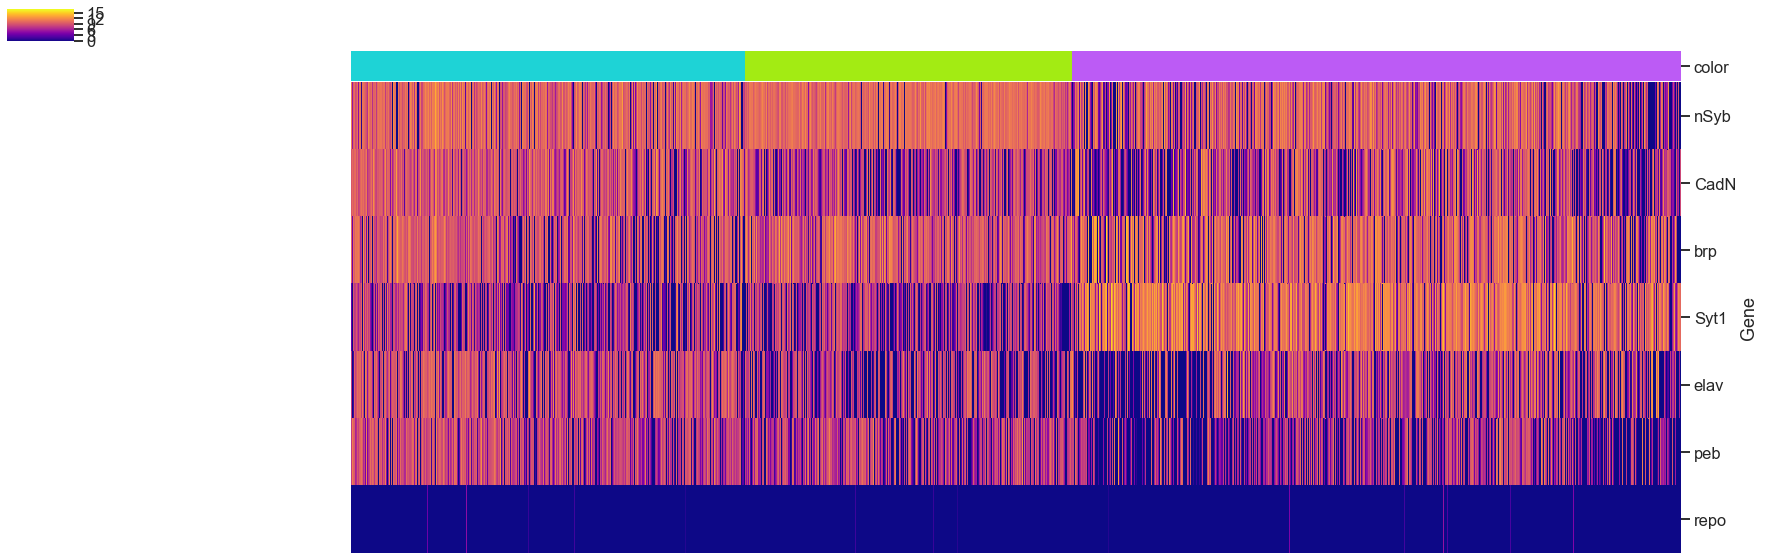

In [13]:
# Calculate clustering and plot
col_colors = df_libs.loc[Z.columns]["color"]
cm = sns.clustermap(Z, method="complete", cmap="plasma", figsize=(30,10), col_colors=col_colors,row_cluster=False, col_cluster=False) 
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_ylabel("Gene")
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])

# tSNE plot using DE genes from each time point

In [14]:
X1 = df_All_ORN
Z1 = X1.loc[DE_genes]
Z1.shape

(416, 4131)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4131 samples in 0.016s...
[t-SNE] Computed neighbors for 4131 samples in 0.290s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4131
[t-SNE] Computed conditional probabilities for sample 2000 / 4131
[t-SNE] Computed conditional probabilities for sample 3000 / 4131
[t-SNE] Computed conditional probabilities for sample 4000 / 4131
[t-SNE] Computed conditional probabilities for sample 4131 / 4131
[t-SNE] Mean sigma: 0.116217
[t-SNE] Computed conditional probabilities in 0.199s
[t-SNE] Iteration 50: error = 16.9876957, gradient norm = 0.0081107 (50 iterations in 0.614s)
[t-SNE] Iteration 100: error = 16.5409660, gradient norm = 0.0040486 (50 iterations in 0.566s)
[t-SNE] Iteration 150: error = 16.4058971, gradient norm = 0.0028763 (50 iterations in 0.580s)
[t-SNE] Iteration 200: error = 16.3380375, gradient norm = 0.0014772 (50 iterations in 0.576s)
[t-SNE] Iteration 250: error = 16.2952194, gradient norm = 0.001269

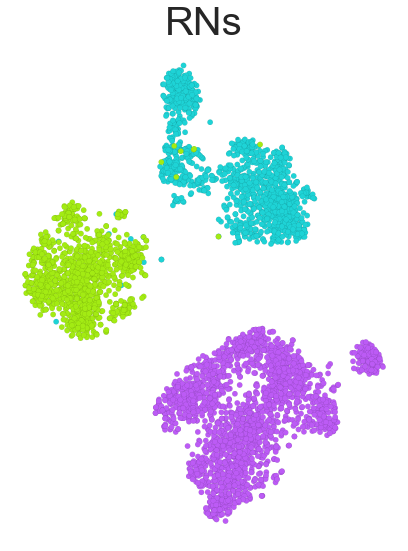

In [15]:
from sklearn.decomposition import PCA

for i in range(35,36):
    myPCA = sct_py3.PCA(Z1, X1, i) # number of significant PCs was determined using shuffling performed elsewhere in parallel fashion
    myPCA.pca()
    Z_pca = pd.DataFrame(myPCA.X_pca.T)

    for j in range(40,41):
        from sklearn.manifold import TSNE
        myTSNE = sct_py3.TSNE(Z_pca, X1, df_libs)
        myTSNE.calc_TSNE(perplexity=j, learning_rate=500, random_state=1)
        # Plot TSNE
        fig, ax = plt.subplots(1, 1, figsize=(8,8))
        myTSNE.plot(fig, ax, colorMode="genotype")
        ax.set_title('RNs' , y=1.02, size=40)
        ax.axis('off')
        plt.tight_layout() 

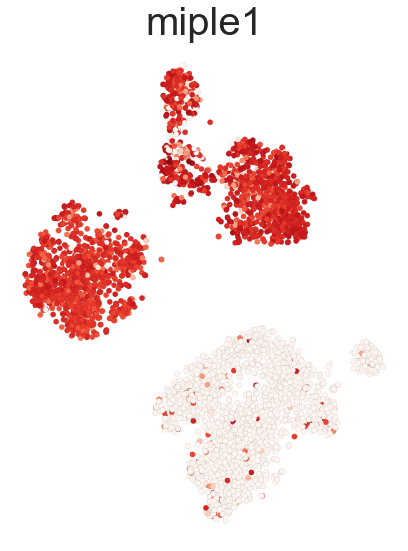

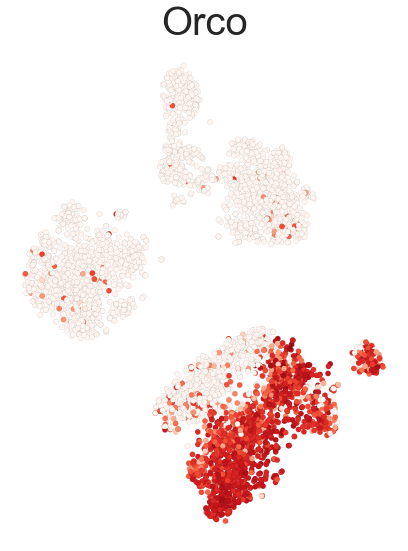

In [16]:
myGene = ['miple1', 'Orco',]
for gene in myGene:
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    sc = myTSNE.plot(fig, ax, colorBy=gene, cmap="Reds")
    ax.set_aspect("equal")
    ax.set_title(gene, y= 1.02, size=40)
    ax.axis('off')
    plt.tight_layout()

# calculate genes detected in 24h and adult 

In [17]:
ORN_genes = pd.read_csv('../data/Figure1/ORN_24_adult_gene_count_pluslam.csv', header=0, index_col=0 )

ORN_genes.tail()

,ORNcell_24h_ElavCD8GFP_P1_A10,ORNcell_24h_ElavCD8GFP_P1_A11,ORNcell_24h_ElavCD8GFP_P1_A12,ORNcell_24h_ElavCD8GFP_P1_A15,ORNcell_24h_ElavCD8GFP_P1_A16,ORNcell_24h_ElavCD8GFP_P1_A17,ORNcell_24h_ElavCD8GFP_P1_A18,ORNcell_24h_ElavCD8GFP_P1_A19,ORNcell_24h_ElavCD8GFP_P1_A1,ORNcell_24h_ElavCD8GFP_P1_A20,...,ORN_10day_nuclei_P3_O22,ORN_10day_nuclei_P3_O2,ORN_10day_nuclei_P3_O3,ORN_10day_nuclei_P3_O5,ORN_10day_nuclei_P3_O6,ORN_10day_nuclei_P3_O9,ORN_10day_nuclei_P3_P12,ORN_10day_nuclei_P3_P6,ORN_10day_nuclei_P3_P8,ORN_10day_nuclei_P3_P9
Rap2l,7.837737,0.000000,0.000000,9.058424,0.000000,2.719587,0.000000,6.412851,8.302376,0.000000,...,1.404445,0.0,0.0,0.0,8.300308,0.0,0.0,0.0,0.0,0.0
mCD8-GFP,12.162839,9.833954,11.420075,12.763710,13.364811,13.212231,13.443375,9.616082,13.908145,13.356032,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
GAL4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
flp,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
gene_count,1453.000000,1807.000000,2154.000000,2260.000000,3108.000000,2012.000000,1068.000000,2550.000000,1889.000000,2698.000000,...,1644.000000,1578.0,861.0,1550.0,1585.000000,394.0,482.0,950.0,353.0,1365.0


In [18]:
df_star= ORN_genes.T

In [19]:
df_star1 = df_star.loc[:,"gene_count"]

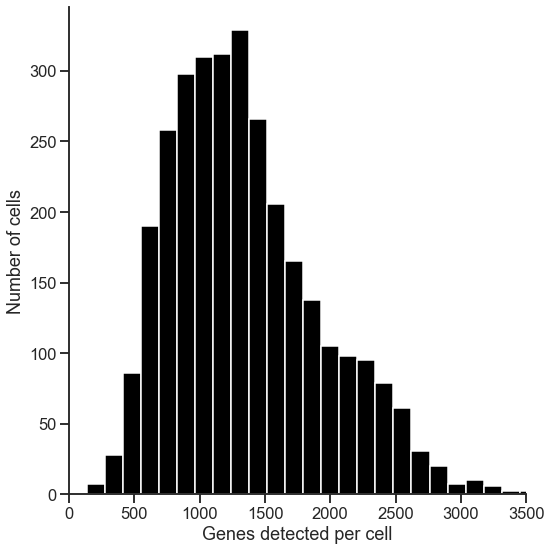

In [20]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.hist(df_star1, bins=30, color=["black"])

ax.set_xscale('linear')
ax.set_xlim(0,3500)
ax.set_xlabel("Genes detected per cell")
ax.set_ylabel("Number of cells")
sns.despine()
plt.tight_layout()

# open raw counts to plot reads #s

In [21]:
ORN_unique = pd.read_csv('../data/Figure1/ORN_24_adult_uniquely_mapped_lamadult.csv', header=0, index_col=0)

ORN_unique.tail()

,7SLRNA:CR32864,a,abd-A,Abd-B,Abl,abo,ac,Ace,acj6,Acph-1,...,CR46300,elgi,CG46301,Rpp30,Tlk,muc,THG,Rap2l,mCD8-GFP,uniquely_mapped
ORN_10day_nuclei_P3_O9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2033.0,11.0,0.0,...,0.0,0.0,0.0,0.0,217.0,0.0,0.0,0.0,0.0,360766.0
ORN_10day_nuclei_P3_P12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67845.0
ORN_10day_nuclei_P3_P6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,643.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,389631.0
ORN_10day_nuclei_P3_P8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2764.0,0.0,0.0,0.0,0.0,248475.0
ORN_10day_nuclei_P3_P9,0.0,0.0,0.0,0.0,174.0,0.0,0.0,0.0,341.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,501948.0


In [22]:
ORN_unique.head()

,7SLRNA:CR32864,a,abd-A,Abd-B,Abl,abo,ac,Ace,acj6,Acph-1,...,CR46300,elgi,CG46301,Rpp30,Tlk,muc,THG,Rap2l,mCD8-GFP,uniquely_mapped
ORNcell_24h_ElavCD8GFP_P1_A10,0.0,0.0,0.0,0.0,290.0,0.0,0.0,0.0,53.0,0.0,...,0.0,0.0,0.0,0.0,13.0,0.0,0.0,94.0,1892.0,412702.0
ORNcell_24h_ElavCD8GFP_P1_A11,2.0,0.0,0.0,0.0,2664.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,86.0,0.0,204.0,0.0,0.0,0.0,1947.0,2135635.0
ORNcell_24h_ElavCD8GFP_P1_A12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,601.0,26.0,0.0,...,0.0,0.0,40.0,0.0,1.0,0.0,0.0,0.0,1814.0,662233.0
ORNcell_24h_ElavCD8GFP_P1_A15,0.0,0.0,0.0,0.0,632.0,0.0,0.0,0.0,38.0,0.0,...,0.0,4.0,125.0,0.0,43.0,190.0,0.0,452.0,5906.0,849369.0
ORNcell_24h_ElavCD8GFP_P1_A16,0.0,0.0,0.0,0.0,132.0,0.0,0.0,328.0,435.0,0.0,...,0.0,207.0,38.0,0.0,136.0,6.0,0.0,0.0,7079.0,671126.0


In [23]:
df_star2 = ORN_unique.loc[:,"uniquely_mapped"]

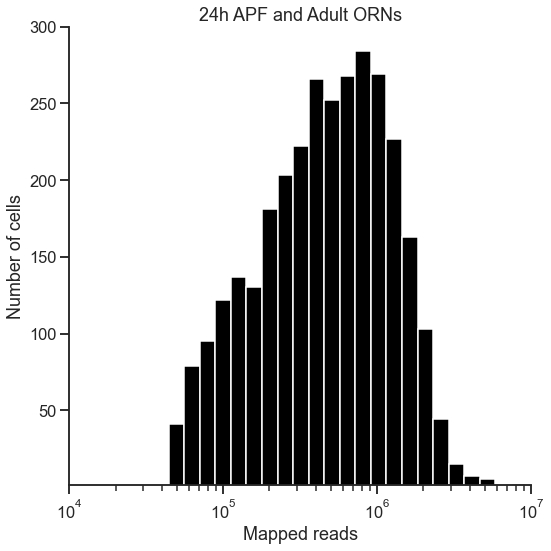

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.hist(df_star2, bins=np.logspace(0,10, 100), color=['black'])

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim(1, 300)
ax.set_xlim(1e4, 1e7)
ax.set_xlabel("Mapped reads")
ax.set_ylabel("Number of cells")
sns.despine()
plt.title("24h APF and Adult ORNs")
plt.tight_layout()
